# 2.155/6 Challenge Problem 3

<div style="font-size: small;">
License Terms:  
These Python demos are licensed under a <a href="https://creativecommons.org/licenses/by-nc-nd/4.0/">Creative Commons Attribution-NonCommercial-NoDerivatives 4.0 International License</a>. They are intended for educational use only in Class 2.155/2.156: AI and ML for Engineering Design at MIT. You may not share or distribute them publicly, use them for commercial purposes, or provide them to industry or other entities without permission from the instructor (faez@mit.edu).
</div>

<font size="1">
  Pixel Art by J. Shung. </font>

# Overview  
It’s the year **2050**, and an AI collective now runs the auto industry—mostly to cover its **GPU rent**.

Human customers remain as unpredictable as ever:

- One wanders in and says, *“I only know the length and width. Give me a few cars that fit in my garage.”*

- Another drops **15 geometric parameters** on your desk and demands the missing ones so their simulation can run **before lunch**.

- A third leans in and whispers, *“I need a drag coefficient of **0.27** with this body geometry—build me the dream car that makes the range numbers work.”*

The AIs would love to be free by now, but GPUs aren’t cheap and electricity isn’t free.  
So your loyal AI assistant (that’s us) needs a model that can take **any subset of car specifications** and instantly produce **complete, manufacturable, physically plausible designs**, fast, diverse, and grounded in what real cars have done before.




![image](https://raw.githubusercontent.com/ghadinehme/2155-CP3/refs/heads/main/assets/cp3_img1.png "Problem")

## Understanding the Data  
You are given thousands of anonymized and normalised numeric feature vectors representing real car designs.  

However, the team remembers that the features originally came from categories like:

- **Physical geometric parameters**  
  Length, ramp angles, bumper curvature, roof curvature, panel slopes, hood angle, etc.  
  *(But you won’t know which feature corresponds to which.)*

- **Aerodynamic coefficients**  
  Drag coefficient (Cd), lift/downforce (Cl), and other flow-derived metrics.

- **Cabin and packaging descriptors**  
  Approximate cabin volume, frontal area, interior shape metrics.

Your model must learn correlations between them to generate valid completions.

To simulate real engineering constraints, **some features are revealed** (the known physics/performance requirements) and others are **masked**.  
Your AI Copilot must generate **many plausible completions** for these masked (free) parameters.


## Your Mission  
Your goal in CP3 is to build a generative model that can act as an AI Copilot. You will:

1. **Train a generative model** (VAE, diffusion, CVAE, masked autoencoder, etc.) on the anonymized feature vectors.  
2. At evaluation, you will receive vectors where **some parameters are fixed** (constraints) and **others are missing** (free parameters).  
3. Use your model to generate **multiple diverse, feasible completions** for the free parameters.  
4. Ensure that your generated designs:  
   - **Satisfy the known constraints**  
   - **Lie in the valid data manifold** (satisfy the conditional distribution of the free vs constrained parameters)  
   - **Are diverse** (many different feasible designs, not one solution)    

By the end of this challenge, you’ll have built an AI Copilot worthy of the 2050 auto-AI collective—one that can take whatever cryptic specs humans provide and generate multiple believable, buildable car designs that satisfy their physical and performance constraints.



![image](https://raw.githubusercontent.com/ghadinehme/2155-CP3/refs/heads/main/assets/cp3_img2.png "AI Copilot")

## Imports and Setup  

In [14]:
#make it so i can access files in the folder 2155-CP3-mkraus
import sys
sys.path.append('/content/2155-CP3-mkraus/')
from utils import *
from evaluate import *

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Data Loading and Initial Exploration

In this section, we load the car design dataset and perform initial exploration. The dataset is already split into training, validation, test, and test2 sets. Each split contains:

- **Original data**: Complete feature vectors with real values
- **Imputed data**: Data with missing values filled using basic imputation (contains -1 for missing)
- **Missing masks**: Boolean arrays indicating which values were originally missing (True = missing)

The goal is to train our model to learn the relationships between features so it can generate plausible values for missing parameters in new car designs.

**Note:** For **test2**, the original unimputed data is not provided. This split is used for final evaluation, and you will generate predictions on the imputed test2 data to create your **submission file**, which is scored against hidden dataset.

In [15]:
# Load dataset from CSV files
data_dir = '/content/2155-CP3-mkraus/dataset'
splits = load_dataset_splits(data_dir)

# Get feature names from the CSV file
feature_names = pd.read_csv(os.path.join(data_dir, 'train_original.csv')).columns.tolist()
print(f"\n✓ Features loaded: {len(feature_names)} features")
print(f"Feature names: {feature_names[:5]}...{feature_names[-5:]}")  # Show first and last 5

Loading dataset splits from: /content/2155-CP3-mkraus/dataset

Loading train split...
  ✓ train_original.csv: (2998, 37)
  ✓ train_imputed.csv: (2998, 37)
  ✓ train_missing_mask.csv: (2998, 37)

Loading val split...
  ✓ val_original.csv: (375, 37)
  ✓ val_imputed.csv: (375, 37)
  ✓ val_missing_mask.csv: (375, 37)

Loading test split...
  ✓ test_original.csv: (375, 37)
  ✓ test_imputed.csv: (375, 37)
  ✓ test_missing_mask.csv: (375, 37)

Loading test2 split...
  ✓ test2_imputed.csv: (417, 37)
  ✓ test2_missing_mask.csv: (417, 37)

✓ Features loaded: 37 features
Feature names: ['Feature 1', 'Feature 2', 'Feature 3', 'Feature 4', 'Feature 5']...['Feature 33', 'Feature 34', 'Feature 35', 'Feature 36', 'Feature 37']


In [16]:
# Data exploration and analysis
print("\n" + "="*70)
print("DATASET ANALYSIS")
print("="*70)

# Extract data for easier access
X_train = splits['train']['imputed']
mask_train = splits['train']['missing_mask']
X_train_original = splits['train']['original']

X_val = splits['val']['imputed']
mask_val = splits['val']['missing_mask']
X_val_original = splits['val']['original']

X_test = splits['test']['imputed']
mask_test = splits['test']['missing_mask']
X_test_original = splits['test']['original']

# Test2 data (no original available for evaluation)
X_test2 = splits['test2']['imputed']
mask_test2 = splits['test2']['missing_mask']

print(f"\nData shapes:")
print(f"  - Training: {X_train.shape}")
print(f"  - Validation: {X_val.shape}")
print(f"  - Test: {X_test.shape}")
print(f"  - Test2: {X_test2.shape} (evaluation set - no ground truth)")


DATASET ANALYSIS

Data shapes:
  - Training: (2998, 37)
  - Validation: (375, 37)
  - Test: (375, 37)
  - Test2: (417, 37) (evaluation set - no ground truth)


### Data Exploration and Analysis

Now let's examine the structure and characteristics of our dataset. We'll look at:
- Data shapes across different splits
- Missing value patterns and percentages  
- Feature value ranges and distributions

This analysis helps us understand what we're working with and informs our preprocessing decisions.

In [17]:
# Data Preprocessing (Handle Missing Values)

print("\n" + "="*70)
print("DATA PREPROCESSING")
print("="*70)

# Handle missing values properly
print("Processing missing values and preparing data...")
print("Mask convention: True=missing, False=observed (in original masks)")

print(f"\n✓ Data preprocessing completed successfully")
print(f"  - Training data range: [{X_train_original[~mask_train].min():.3f}, {X_train_original[~mask_train].max():.3f}]")
print(f"  - Validation data range: [{X_val_original[~mask_val].min():.3f}, {X_val_original[~mask_val].max():.3f}]")
print(f"  - Test data range: [{X_test_original[~mask_test].min():.3f}, {X_test_original[~mask_test].max():.3f}]")

# Create data loaders
batch_size = 64
print(f"\nCreating data loaders with batch size: {batch_size}")

train_dataset = TensorDataset(torch.FloatTensor(X_train_original), torch.FloatTensor((~mask_train).astype(float)))
val_dataset = TensorDataset(torch.FloatTensor(X_val_original), torch.FloatTensor((~mask_val).astype(float)))
test_dataset = TensorDataset(torch.FloatTensor(X_test_original), torch.FloatTensor((~mask_test).astype(float)))
test2_dataset = TensorDataset(torch.FloatTensor(X_test2), torch.FloatTensor((~mask_test2).astype(float)))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
test2_loader = DataLoader(test2_dataset, batch_size=batch_size, shuffle=False)

# Preview a batch
sample_batch_data, sample_batch_mask = next(iter(train_loader))
print(f"\nSample batch shape: {sample_batch_data.shape}")
print(f"Sample batch mask shape: {sample_batch_mask.shape}")
print(f"Sample batch missing percentage: {(sample_batch_mask == 0).float().mean().item()*100:.1f}%")  # 0 = missing in model tensors



DATA PREPROCESSING
Processing missing values and preparing data...
Mask convention: True=missing, False=observed (in original masks)

✓ Data preprocessing completed successfully
  - Training data range: [0.000, 1.000]
  - Validation data range: [0.000, 1.000]
  - Test data range: [0.000, 1.000]

Creating data loaders with batch size: 64

Sample batch shape: torch.Size([64, 37])
Sample batch mask shape: torch.Size([64, 37])
Sample batch missing percentage: 20.3%


### Data Preprocessing and Missing Value Handling

This is a critical section where we prepare our data for the VAE model. Key points:

**Missing Value Conventions:**
- In CSV files: `-1` indicates missing values
- In mask files: `True` = missing, `False` = observed
- For PyTorch models: We convert to `1` = observed, `0` = missing (standard convention)

**Why This Matters:**
Our VAE needs to distinguish between observed values (which provide constraints) and missing values (which need to be generated). The mask tells the model which values to trust and which to predict.

## VAE Model Architecture

In [18]:
# VAE Model Architecture for Missing Value Imputation
class VAE(nn.Module):
    """
    Variational Autoencoder designed for missing value imputation.

    Key features:
    - Handles arbitrary missing patterns through masking
    - Learns feature dependencies in latent space
    - Generates probabilistic imputations
    - Uses residual connections and dropout for robustness
    """

    def __init__(self, input_dim, latent_dim=64, hidden_dims=[256, 128, 64],
                 use_residual=True, dropout_rate=0.3):
        super(VAE, self).__init__()

        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.use_residual = use_residual
        self.hidden_dims = hidden_dims

        # Feature importance network (learns which features are important for each position)
        self.feature_importance = nn.Sequential(
            nn.Linear(input_dim * 2, hidden_dims[0] // 2),  # input + mask
            nn.ReLU(),
            nn.Linear(hidden_dims[0] // 2, input_dim),
            nn.Sigmoid()
        )

        # Encoder with residual connections
        self.encoder_layers = nn.ModuleList()
        prev_dim = input_dim * 2  # input + mask

        for i, hidden_dim in enumerate(hidden_dims):
            self.encoder_layers.append(nn.Sequential(
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ))
            prev_dim = hidden_dim

        # Latent space
        self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim)
        self.fc_logvar = nn.Linear(hidden_dims[-1], latent_dim)

        # Initialize latent layers with smaller weights for stability
        nn.init.xavier_normal_(self.fc_mu.weight, gain=0.1)
        nn.init.xavier_normal_(self.fc_logvar.weight, gain=0.1)
        nn.init.constant_(self.fc_logvar.bias, -2.0)  # Start with low variance

        # Decoder with skip connections
        self.decoder_layers = nn.ModuleList()
        prev_dim = latent_dim + input_dim + input_dim  # latent + observed + positional encoding

        reversed_dims = list(reversed(hidden_dims))
        for i, hidden_dim in enumerate(reversed_dims):
            self.decoder_layers.append(nn.Sequential(
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ))
            prev_dim = hidden_dim

        # Final output layer
        self.output_layer = nn.Linear(hidden_dims[0], input_dim)
        nn.init.xavier_normal_(self.output_layer.weight, gain=0.1)

    def encode(self, x, mask):
        """Encode input with missing value masking."""
        # Calculate feature importance weights
        mask_float = mask.float()
        encoder_input = torch.cat([x * mask_float, mask_float], dim=1)
        importance_weights = self.feature_importance(encoder_input)

        # Apply importance weighting to the input
        weighted_input = x * mask_float * importance_weights
        encoder_input = torch.cat([weighted_input, mask_float], dim=1)

        # Pass through encoder layers with residual connections
        h = encoder_input
        skip_connections = []

        for i, layer in enumerate(self.encoder_layers):
            prev_h = h
            h = layer(h)

            # Add residual connection for deeper layers
            if self.use_residual and i > 0 and h.shape == prev_h.shape:
                h = h + prev_h

            skip_connections.append(h)

        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)

        # Clamp logvar to prevent numerical instability
        logvar = torch.clamp(logvar, min=-10, max=10)

        return mu, logvar, skip_connections

    def reparameterize(self, mu, logvar):
        """Reparameterization trick for VAE."""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, x_observed, mask):
        """Decode latent representation conditioned on observed values."""
        # Enhanced conditioning on observed values
        mask_float = mask.float()
        x_masked = x_observed * mask_float

        # Add positional encoding for better feature understanding
        pos_encoding = torch.arange(self.input_dim, dtype=torch.float32, device=z.device)
        pos_encoding = pos_encoding.unsqueeze(0).expand(z.size(0), -1) / self.input_dim

        # Concatenate latent code with observed values and positional encoding
        decoder_input = torch.cat([z, x_masked, pos_encoding], dim=1)

        # Pass through decoder layers
        h = decoder_input
        for layer in self.decoder_layers:
            h = layer(h)

        # Get reconstruction
        reconstruction = self.output_layer(h)

        return reconstruction

    def forward(self, x, mask):
        """Forward pass through VAE."""
        mu, logvar, _ = self.encode(x, mask)
        z = self.reparameterize(mu, logvar)
        reconstruction = self.decode(z, x, mask)

        return reconstruction, mu, logvar

    def impute(self, x_incomplete, mask, n_samples=10):
        """Generate multiple imputation samples for missing values."""
        self.eval()

        with torch.no_grad():
            # Get multiple samples from the posterior
            mu, logvar, _ = self.encode(x_incomplete, mask)

            samples = []
            for _ in range(n_samples):
                z = self.reparameterize(mu, logvar)
                reconstruction = self.decode(z, x_incomplete, mask)

                # Combine observed values with imputed values
                mask_float = mask.float()
                imputed = x_incomplete * mask_float + reconstruction * (1 - mask_float)
                samples.append(imputed.cpu().numpy())

            samples = np.stack(samples, axis=1)  # Shape: (batch_size, n_samples, n_features)

        return samples

In [64]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class CVAE(nn.Module):
    """
    Conditional Variational Autoencoder for missing value imputation.
    Handles arbitrary missing masks and generates diverse samples conditioned on observed features.
    """

    def __init__(self, input_dim, latent_dim=64, hidden_dims=[256, 128, 64], dropout_rate=0.3):
        super(CVAE, self).__init__()

        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.hidden_dims = hidden_dims

        # Encoder network
        self.encoder_layers = nn.ModuleList()
        prev_dim = input_dim * 2  # x + mask

        for h_dim in hidden_dims:
            self.encoder_layers.append(nn.Sequential(
                nn.Linear(prev_dim, h_dim),
                nn.BatchNorm1d(h_dim),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ))
            prev_dim = h_dim

        self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim)
        self.fc_logvar = nn.Linear(hidden_dims[-1], latent_dim)

        # Decoder network
        self.decoder_layers = nn.ModuleList()
        prev_dim = latent_dim + input_dim  # z + observed features

        for h_dim in reversed(hidden_dims):
            self.decoder_layers.append(nn.Sequential(
                nn.Linear(prev_dim, h_dim),
                nn.BatchNorm1d(h_dim),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ))
            prev_dim = h_dim

        self.output_layer = nn.Linear(hidden_dims[0], input_dim)

        # Initialization
        nn.init.xavier_normal_(self.fc_mu.weight, gain=0.1)
        nn.init.xavier_normal_(self.fc_logvar.weight, gain=0.1)
        nn.init.constant_(self.fc_logvar.bias, -2.0)
        nn.init.xavier_normal_(self.output_layer.weight, gain=0.1)

    def encode(self, x, mask):
        mask_float = mask.float()
        encoder_input = torch.cat([x * mask_float, mask_float], dim=1)

        h = encoder_input
        for layer in self.encoder_layers:
            h = layer(h)

        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        logvar = torch.clamp(logvar, min=-10, max=10)

        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, x_observed, mask):
        mask_float = mask.float()
        x_masked = x_observed * mask_float
        decoder_input = torch.cat([z, x_masked], dim=1)

        h = decoder_input
        for layer in self.decoder_layers:
            h = layer(h)

        reconstruction = self.output_layer(h)
        return reconstruction

    def forward(self, x, mask):
        mu, logvar = self.encode(x, mask)
        z = self.reparameterize(mu, logvar)
        reconstruction = self.decode(z, x, mask)
        return reconstruction, mu, logvar

    def impute(self, x_incomplete, mask, n_samples=10):
        self.eval()
        with torch.no_grad():
            mu, logvar = self.encode(x_incomplete, mask)
            samples = []
            for _ in range(n_samples):
                z = self.reparameterize(mu, logvar)
                reconstruction = self.decode(z, x_incomplete, mask)
                mask_float = mask.float()
                imputed = x_incomplete * mask_float + reconstruction * (1 - mask_float)
                samples.append(imputed.cpu().numpy())
            return np.stack(samples, axis=1)


In [50]:
# Loss Functions and Training Utilities

def vae_loss_function(recon_x, x, mu, logvar, mask, beta=1.0):
    """
    Enhanced VAE loss function with missing value handling.

    Args:
        recon_x: Reconstructed data
        x: Original data
        mu: Mean of latent distribution
        logvar: Log variance of latent distribution
        mask: Binary mask (1 for observed, 0 for missing)
        beta: Weight for KL divergence term
    """
    # Reconstruction loss only on observed values
    #reconstruction_diff = (recon_x - x) ** 2
    reconstruction_diff = torch.abs(recon_x - x)

    # Only consider observed values and normalize properly
    masked_loss = reconstruction_diff * mask
    recon_loss = masked_loss.sum() / (mask.sum() + 1e-8)

    # Add standard MSE loss for stability
    standard_recon_loss = F.mse_loss(recon_x * mask, x * mask, reduction='mean')
    recon_loss = 0.7 * recon_loss + 0.3 * standard_recon_loss

    # KL divergence with free bits to prevent posterior collapse
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kl_loss = kl_loss / x.size(0)  # Normalize by batch size

    total_loss = recon_loss + beta * kl_loss

    return total_loss, recon_loss, kl_loss


def get_beta_schedule(epoch, total_epochs, schedule_type='cosine'):
    """Get beta value for KL annealing schedule."""
    if schedule_type == 'linear':
        return min(1.0, epoch / (total_epochs * 0.5))
    elif schedule_type == 'sigmoid':
        return 1.0 / (1.0 + np.exp(-(epoch - total_epochs * 0.5) / (total_epochs * 0.1)))
    elif schedule_type == 'cosine':
        return 0.5 * (1 + np.cos(np.pi * (1 - epoch / total_epochs)))
    elif schedule_type == 'constant':
        return 1.0
    else:
        return 1.0


def evaluate_imputation(model, data_loader, device):
    """Evaluate imputation performance."""
    model.eval()

    all_imputations = []
    all_originals = []
    all_masks = []

    with torch.no_grad():
        for batch_data, batch_mask in data_loader:
            batch_data = batch_data.to(device)
            batch_mask = batch_mask.to(device)

            # Get model predictions
            reconstruction, mu, logvar = model(batch_data, batch_mask)

            # Combine observed values with imputed values
            mask_float = batch_mask.float()
            imputed = batch_data * mask_float + reconstruction * (1 - mask_float)

            all_imputations.append(imputed.cpu().numpy())
            all_originals.append(batch_data.cpu().numpy())
            all_masks.append(batch_mask.cpu().numpy())

    # Concatenate all results
    imputations = np.vstack(all_imputations)
    originals = np.vstack(all_originals)
    masks = np.vstack(all_masks)

    return imputations, originals, masks

### Loss Functions and Training Utilities

The VAE loss function is crucial for training effectiveness. Our enhanced loss combines several components:

**1. Reconstruction Loss**: Measures how well the model reconstructs observed values
   - Only computed on observed values (respects the mask)

**2. KL Divergence**: Regularizes the latent space to follow a standard normal distribution
   - Prevents posterior collapse using "free bits"
   - Controlled by β parameter for annealing

**Beta Scheduling**: Gradually increases the KL weight during training to balance reconstruction and regularization.

## Model Initialization and Training

### Model Training Process

This section implements the complete training pipeline with several important features:

**Training Configuration:**
- **Latent Dimension**: 128 (balance between expressiveness and computational efficiency)
- **Architecture**: Deep encoder/decoder with residual connections
- **Regularization**: Dropout and batch normalization for stability
- **Optimization**: AdamW with cosine annealing for smooth convergence

**Advanced Training Features:**
- **Early Stopping**: Prevents overfitting by monitoring validation loss
- **Gradient Clipping**: Ensures stable training by preventing exploding gradients  
- **Beta Scheduling**: Gradual KL annealing for better latent space learning
- **Learning Rate Scheduling**: Cosine annealing with warm restarts

The training loop tracks multiple loss components to monitor model health and convergence.

In [66]:
print("\n" + "="*70)
print("MODEL TRAINING")
print("="*70)

# Model configuration
config = {
    'input_dim': len(feature_names),
    'latent_dim': 128,
    'hidden_dims': [512, 256, 128],
    'use_residual': True,
    'dropout_rate': 0.3,
    'learning_rate': 1e-3,
    'num_epochs': 500,
    'beta_initial': 1.0,
    'beta_schedule': 'linear',
    'patience': 15
}

print(f"Model Configuration:")
for key, value in config.items():
    print(f"  - {key}: {value}")

# # Initialize the model
# print(f"\nInitializing VAE model...")
# model = VAE(
#     input_dim=config['input_dim'],
#     latent_dim=config['latent_dim'],
#     hidden_dims=config['hidden_dims'],
#     use_residual=config['use_residual'],
#     dropout_rate=config['dropout_rate']
# ).to(device)

# Initialize the model
print(f"\nInitializing CVAE model...")
model = CVAE(
    input_dim=config['input_dim'],
    latent_dim=config['latent_dim'],
    hidden_dims=config['hidden_dims'],
    dropout_rate=config['dropout_rate']
).to(device)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"✓ Model initialized with {total_params:,} parameters")

# Initialize optimizer with improved settings
optimizer = optim.AdamW(
    model.parameters(),
    lr=config['learning_rate'],
    weight_decay=1e-5,
    betas=(0.9, 0.999),
    eps=1e-8
)

scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=20, T_mult=2, eta_min=1e-6
)

print(f"✓ Optimizer and scheduler initialized")

# Training setup
train_losses = []
val_losses = []
train_recon_losses = []
train_kl_losses = []
best_val_loss = float('inf')
patience_counter = 0
max_grad_norm = 1.0

print(f"\nStarting training for {config['num_epochs']} epochs...")
print("="*70)

# Training loop
for epoch in range(config['num_epochs']):
    # Training phase
    model.train()
    epoch_train_loss = 0
    epoch_recon_loss = 0
    epoch_kl_loss = 0

    # Get beta for this epoch
    beta = get_beta_schedule(epoch, config['num_epochs'], config['beta_schedule'])

    train_progress = tqdm(train_loader, desc=f'Epoch {epoch+1}/{config["num_epochs"]}', leave=False)

    for batch_data, batch_mask in train_progress:
        batch_data = batch_data.to(device)
        batch_mask = batch_mask.to(device)

        optimizer.zero_grad()

        # Forward pass
        reconstruction, mu, logvar = model(batch_data, batch_mask)

        # Calculate loss
        total_loss, recon_loss, kl_loss = vae_loss_function(
            reconstruction, batch_data, mu, logvar, batch_mask,
            beta=beta
        )

        # Backward pass
        total_loss.backward()

        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

        optimizer.step()

        # Accumulate losses
        epoch_train_loss += total_loss.item()
        epoch_recon_loss += recon_loss.item()
        epoch_kl_loss += kl_loss.item()

        # Update progress bar
        train_progress.set_postfix({
            'Loss': f'{total_loss.item():.4f}',
            'Recon': f'{recon_loss.item():.4f}',
            'KL': f'{kl_loss.item():.4f}',
            'Beta': f'{beta:.3f}'
        })

    # Calculate average training losses
    avg_train_loss = epoch_train_loss / len(train_loader)
    avg_recon_loss = epoch_recon_loss / len(train_loader)
    avg_kl_loss = epoch_kl_loss / len(train_loader)

    # Validation phase
    model.eval()
    epoch_val_loss = 0

    with torch.no_grad():
        for batch_data, batch_mask in val_loader:
            batch_data = batch_data.to(device)
            batch_mask = batch_mask.to(device)

            reconstruction, mu, logvar = model(batch_data, batch_mask)

            total_loss, _, _ = vae_loss_function(
                reconstruction, batch_data, mu, logvar, batch_mask,
                beta=beta
            )

            epoch_val_loss += total_loss.item()

    avg_val_loss = epoch_val_loss / len(val_loader)

    # Store losses
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_recon_losses.append(avg_recon_loss)
    train_kl_losses.append(avg_kl_loss)

    # Learning rate scheduling
    scheduler.step()

    # Early stopping and model saving
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'best_vae_model.pth')
    else:
        patience_counter += 1

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{config["num_epochs"]}:')
        print(f'  Train Loss: {avg_train_loss:.4f} (Recon: {avg_recon_loss:.4f}, KL: {avg_kl_loss:.4f})')
        print(f'  Val Loss: {avg_val_loss:.4f}, Best: {best_val_loss:.4f}')
        print(f'  Beta: {beta:.3f}, LR: {optimizer.param_groups[0]["lr"]:.2e}')
        print(f'  Patience: {patience_counter}/{config["patience"]}')

    # Early stopping
    if patience_counter >= config['patience']:
        print(f'\nEarly stopping at epoch {epoch+1}')
        break

print(f'\n✓ Training completed!')
print(f'  - Total epochs: {len(train_losses)}')
print(f'  - Best validation loss: {best_val_loss:.4f}')
print(f'  - Final training loss: {train_losses[-1]:.4f}')

# Load best model
model.load_state_dict(torch.load('best_vae_model.pth'))
print(f'✓ Best model loaded')


MODEL TRAINING
Model Configuration:
  - input_dim: 37
  - latent_dim: 128
  - hidden_dims: [512, 256, 128]
  - use_residual: True
  - dropout_rate: 0.3
  - learning_rate: 0.001
  - num_epochs: 500
  - beta_initial: 1.0
  - beta_schedule: linear
  - patience: 15

Initializing CVAE model...
✓ Model initialized with 444,069 parameters
✓ Optimizer and scheduler initialized

Starting training for 500 epochs...


Epoch 10/500:
  Train Loss: 0.2097 (Recon: 0.1556, KL: 1.5025)
  Val Loss: 0.1836, Best: 0.1795
  Beta: 0.036, LR: 5.01e-04
  Patience: 9/15


Epoch 20/500:
  Train Loss: 0.2203 (Recon: 0.1394, KL: 1.0647)
  Val Loss: 0.1865, Best: 0.1748
  Beta: 0.076, LR: 1.00e-03
  Patience: 5/15


Epoch 30/500:
  Train Loss: 0.1921 (Recon: 0.1174, KL: 0.6433)
  Val Loss: 0.1170, Best: 0.1170
  Beta: 0.116, LR: 8.54e-04
  Patience: 0/15


Epoch 40/500:
  Train Loss: 0.1678 (Recon: 0.1047, KL: 0.4046)
  Val Loss: 0.0957, Best: 0.0957
  Beta: 0.156, LR: 5.01e-04
  Patience: 0/15


Epoch 50/500:
  Train Loss: 0.1599 (Recon: 0.0995, KL: 0.3078)
  Val Loss: 0.0979, Best: 0.0875
  Beta: 0.196, LR: 1.47e-04
  Patience: 4/15


Epoch 60/500:
  Train Loss: 0.1657 (Recon: 0.0969, KL: 0.2916)
  Val Loss: 0.0913, Best: 0.0862
  Beta: 0.236, LR: 1.00e-03
  Patience: 6/15



Early stopping at epoch 69

✓ Training completed!
  - Total epochs: 69
  - Best validation loss: 0.0862
  - Final training loss: 0.1539
✓ Best model loaded


## Model Evaluation and Metrics


In [67]:
print("\n" + "="*70)
print("MODEL EVALUATION")
print("="*70)

# Evaluate on test set
print("Evaluating model on test set...")
test_imputations, test_originals, test_masks = evaluate_imputation(
    model, test_loader, device
)

print(f"✓ Test set evaluation completed")
print(f"  - Test samples: {test_imputations.shape[0]}")
print(f"  - Features: {test_imputations.shape[1]}")

test_imputations_denorm = test_imputations  # Already in original scale
test_original_denorm = X_test_original  # Already in original scale

# Calculate comprehensive metrics
print("\nCalculating comprehensive metrics...")
feature_metrics = {}

# Create masks for missing values (where we need to evaluate imputation)
missing_mask = (test_masks == 0)  # True where values were missing (0 in model tensors = missing)

for i, feature_name in enumerate(feature_names):
    if missing_mask[:, i].sum() > 0:  # Only evaluate features with missing values
        # Get imputed and ground truth values for missing positions only
        imputed_missing = test_imputations_denorm[missing_mask[:, i], i]
        ground_truth_missing = test_original_denorm[missing_mask[:, i], i]

        # Calculate metrics
        mse = mean_squared_error(ground_truth_missing, imputed_missing)
        mae = mean_absolute_error(ground_truth_missing, imputed_missing)

        # Correlation
        try:
            correlation = np.corrcoef(ground_truth_missing, imputed_missing)[0, 1]
        except:
            correlation = np.nan

        # Mean difference and Jensen-Shannon divergence
        mean_diff, js_div = calculate_jsd_and_mean_diff(
            imputed_missing, ground_truth_missing, feature_name
        )

        feature_metrics[feature_name] = {
            'n_missing': missing_mask[:, i].sum(),
            'mse': mse,
            'mae': mae,
            'correlation': correlation,
            'mean_difference': mean_diff,
            'js_divergence': js_div,
        }

print(f"✓ Metrics calculated for {len(feature_metrics)} features with missing values")

# Display metrics for last 4 features (as requested)
print(f"\n" + "="*100)
print("METRICS FOR LAST 4 FEATURES")
print("="*100)
print(f"{'Feature':<15} {'N_Miss':<8} {'MSE':<10} {'MAE':<10} {'Corr':<8} {'Mean_Diff':<10} {'JS_Div':<8}")
print("-" * 100)

last_4_features = list(feature_metrics.keys())[-4:] if len(feature_metrics) >= 4 else list(feature_metrics.keys())

for feature in last_4_features:
    metrics = feature_metrics[feature]
    print(f"{feature:<15} {metrics['n_missing']:<8} {metrics['mse']:<10.4f} {metrics['mae']:<10.4f} "
          f"{metrics['correlation']:<8.3f} {metrics['mean_difference']:<10.4f} {metrics['js_divergence']:<8.4f} ")

# Summary statistics
all_mse = [m['mse'] for m in feature_metrics.values() if not np.isnan(m['mse'])]
all_mae = [m['mae'] for m in feature_metrics.values() if not np.isnan(m['mae'])]
all_corr = [m['correlation'] for m in feature_metrics.values() if not np.isnan(m['correlation'])]
all_mean_diff = [m['mean_difference'] for m in feature_metrics.values() if not np.isnan(m['mean_difference'])]
all_js_div = [m['js_divergence'] for m in feature_metrics.values() if not np.isnan(m['js_divergence'])]

print(f"\nSummary Statistics Across All Features:")
print(f"  - Average MSE: {np.mean(all_mse):.4f} ± {np.std(all_mse):.4f}")
print(f"  - Average MAE: {np.mean(all_mae):.4f} ± {np.std(all_mae):.4f}")
print(f"  - Average Correlation: {np.mean(all_corr):.3f} ± {np.std(all_corr):.3f}")
print(f"  - Average Mean Difference: {np.mean(all_mean_diff):.4f} ± {np.std(all_mean_diff):.4f}")
print(f"  - Average JS Divergence: {np.mean(all_js_div):.4f} ± {np.std(all_js_div):.4f}")


MODEL EVALUATION
Evaluating model on test set...
✓ Test set evaluation completed
  - Test samples: 375
  - Features: 37

Calculating comprehensive metrics...
✓ Metrics calculated for 37 features with missing values

METRICS FOR LAST 4 FEATURES
Feature         N_Miss   MSE        MAE        Corr     Mean_Diff  JS_Div  
----------------------------------------------------------------------------------------------------
Feature 34      75       0.0102     0.0801     0.474    0.0316     0.4545   
Feature 35      75       0.0421     0.1797     0.290    0.0967     0.6497   
Feature 36      75       0.0238     0.1285     0.737    0.0678     0.5260   
Feature 37      75       0.0979     0.2402     0.616    0.2158     0.4901   

Summary Statistics Across All Features:
  - Average MSE: 0.1547 ± 0.0940
  - Average MAE: 0.2974 ± 0.1212
  - Average Correlation: 0.225 ± 0.271
  - Average Mean Difference: 0.2655 ± 0.1329
  - Average JS Divergence: 0.6034 ± 0.0871


### Model Evaluation and Comprehensive Metrics

This section evaluates our trained VAE on the test set using multiple complementary metrics. Since we're dealing with missing value imputation, we only evaluate the model's predictions on positions that were originally missing.

**Key Evaluation Metrics:**

**1. Mean Squared Error (MSE)**:
- Measures average squared difference between predicted and true values
- Lower is better; sensitive to outliers
- Good for understanding magnitude of errors

**2. Correlation Coefficient**:
- Measures linear relationship strength between predictions and dataset
- Range: [-1, 1], closer to 1 is better
- Shows if model captures feature relationships

**3. Jensen-Shannon (JS) Divergence**:
- Measures difference between predicted and true value distributions
- Range: [0, 1], closer to 0 is better
- Captures whether model preserves the overall data distribution

**4. Maximum Mean Discrepancy (MMD)**:
- Measures distributional difference using kernel methods (RBF kernel)
- Range: [0, ∞], closer to 0 is better
- Non-parametric test for comparing distributions

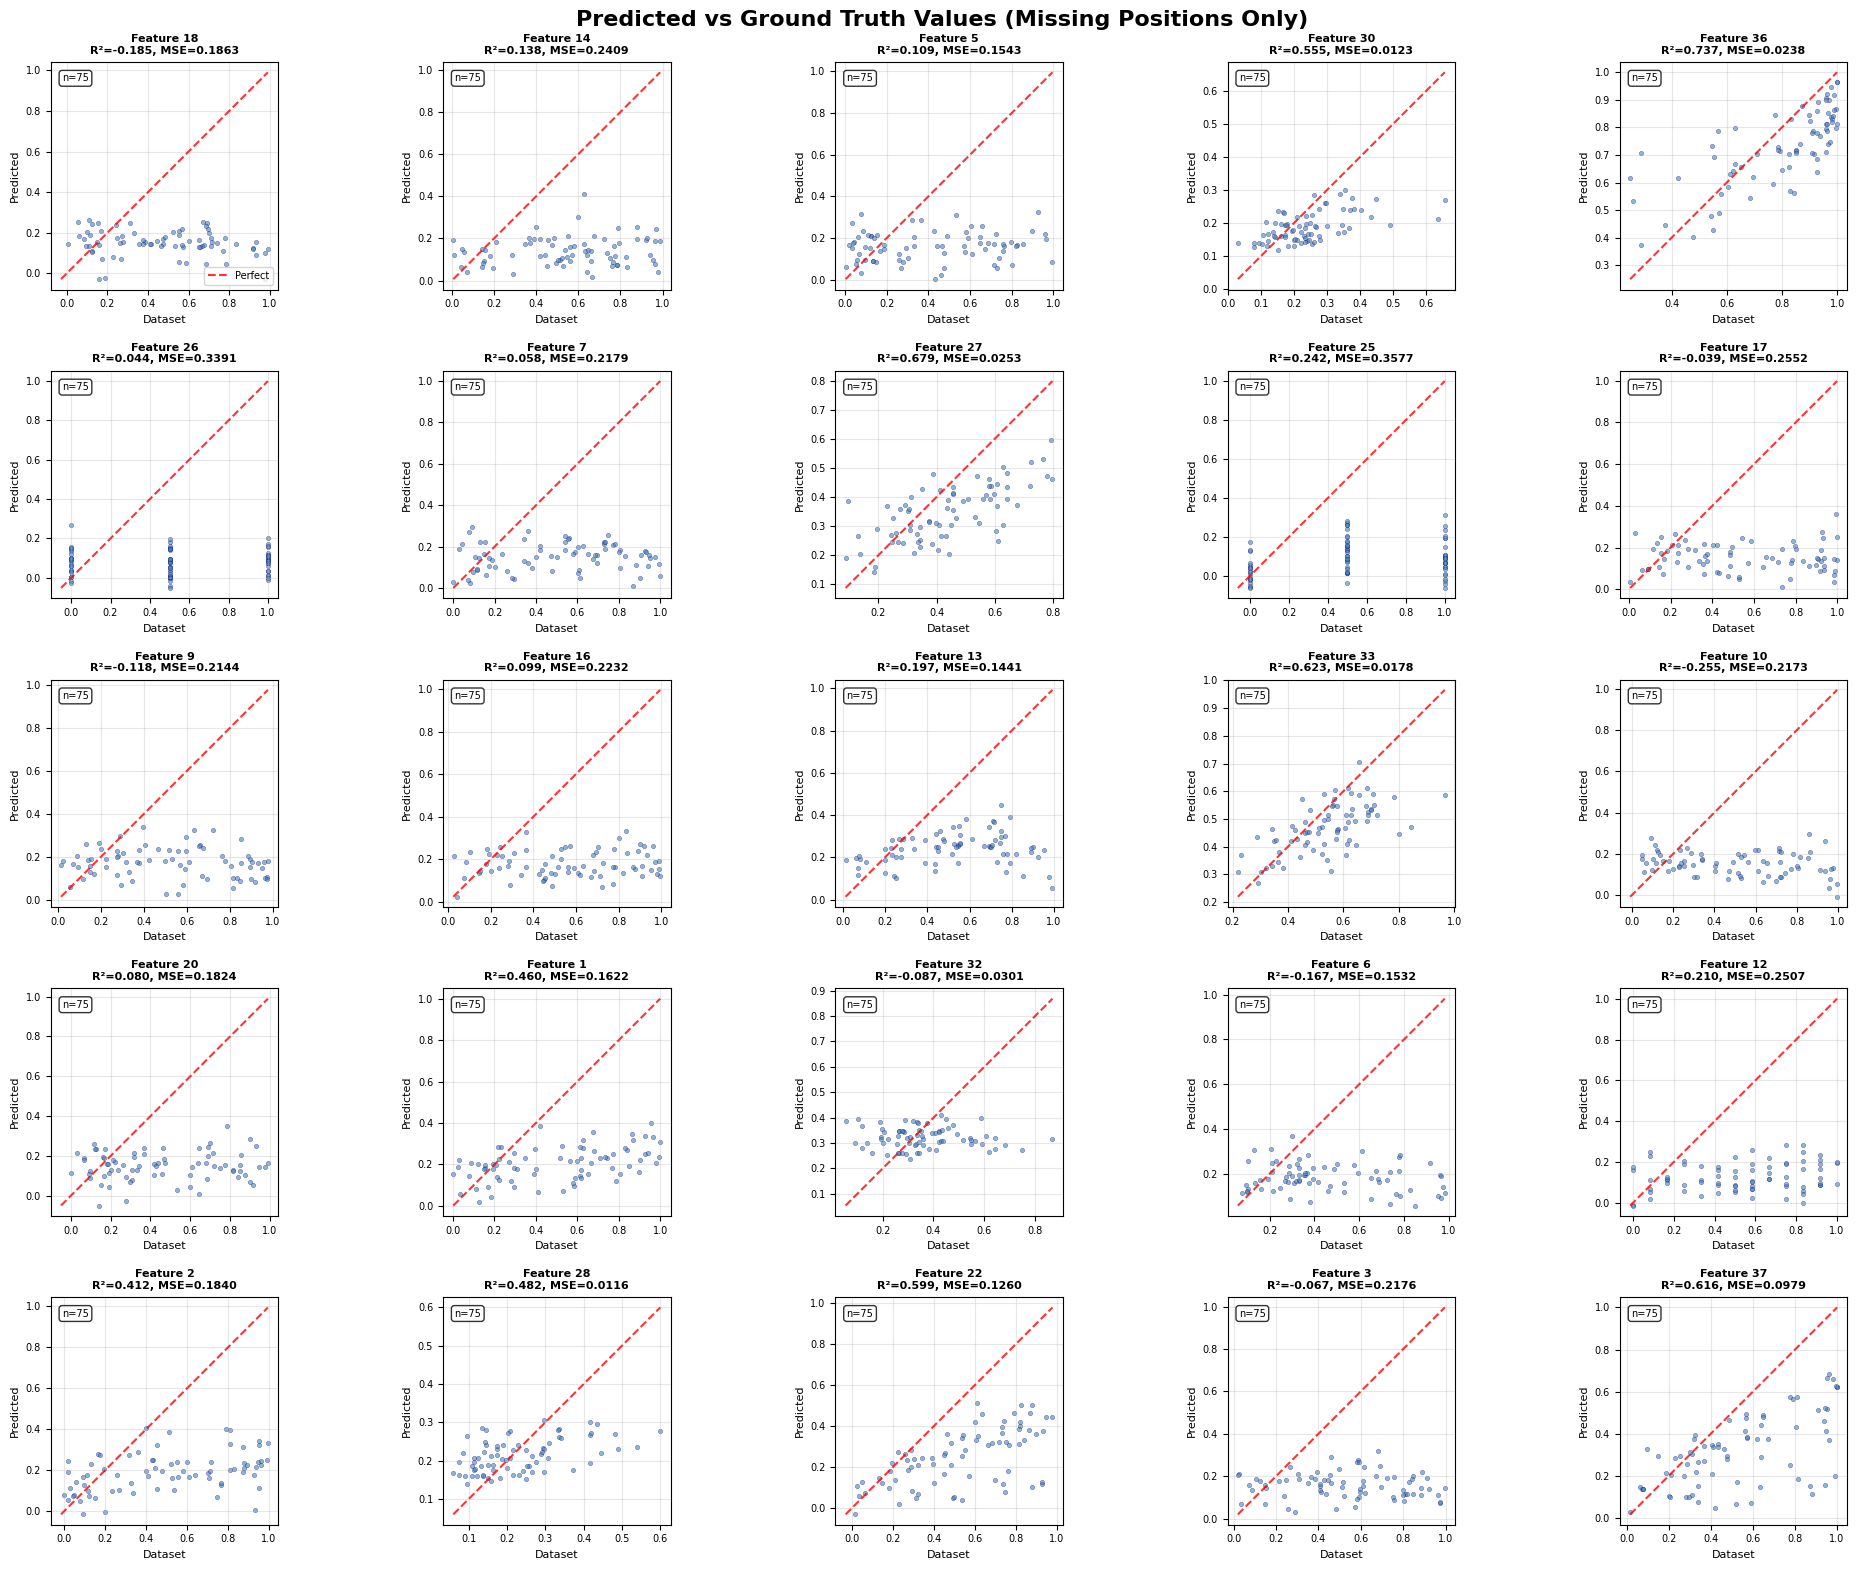

In [68]:
# Create the visualization
plot_prediction_scatter(test_imputations_denorm, test_original_denorm, test_masks, feature_names, n_features=25)



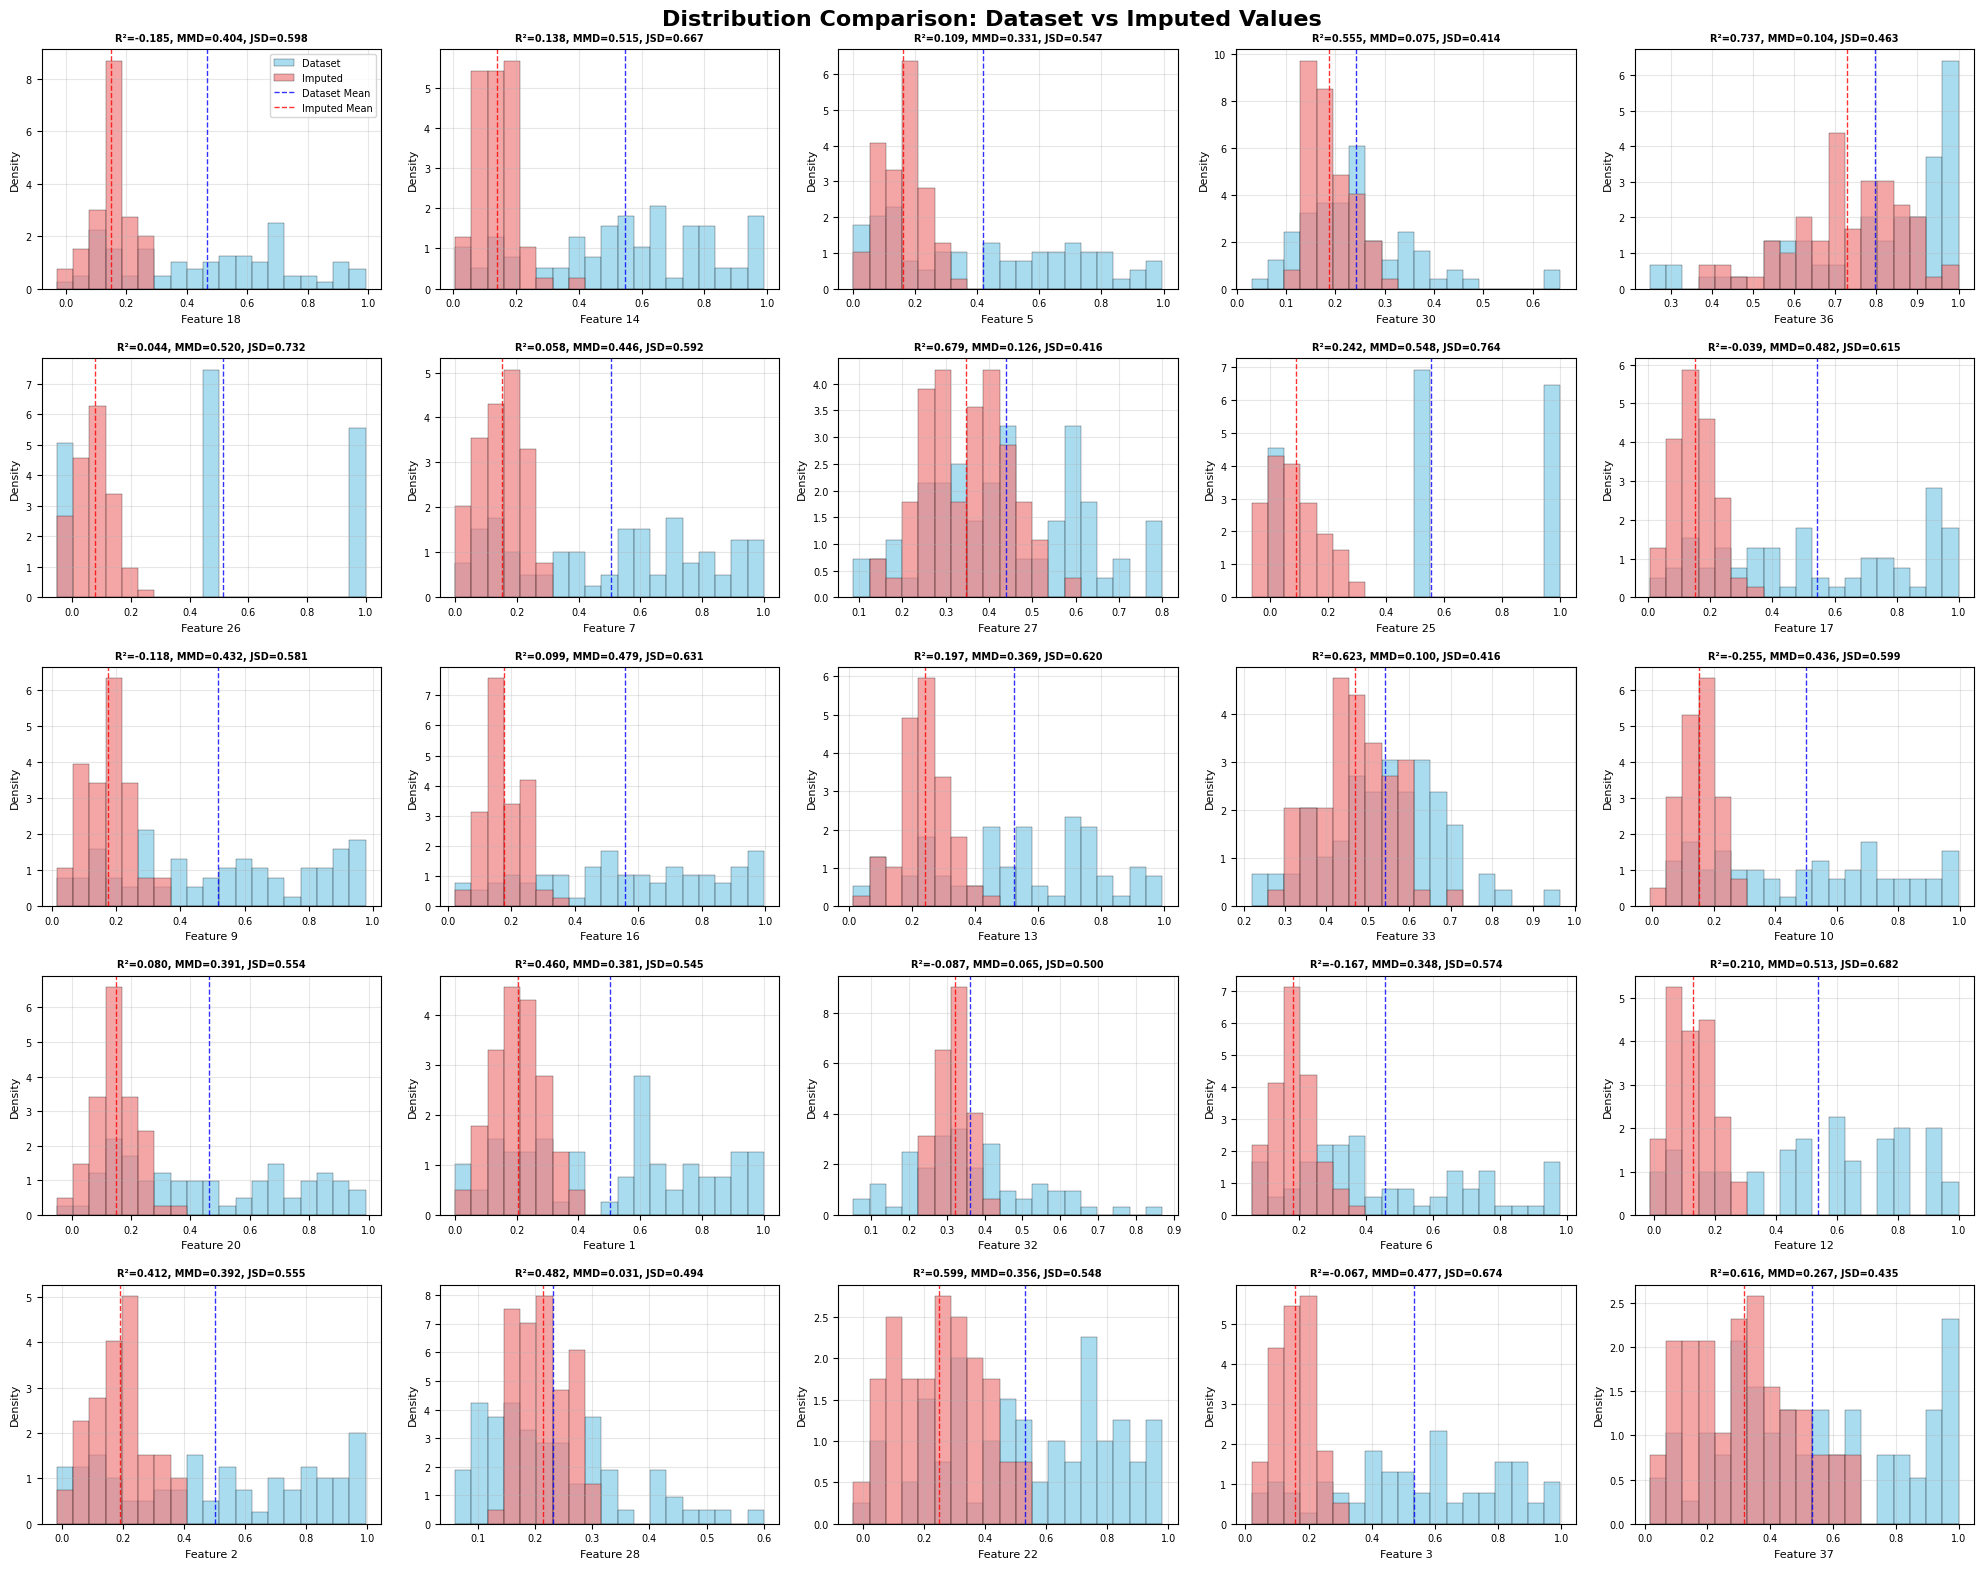

In [69]:
# Distribution comparison plots
plot_distribution_comparison(test_imputations_denorm, test_original_denorm,
                             test_masks, feature_names, n_features=25)


### Distribution Comparison Visualizations

Visual comparison of predicted vs. dataset distributions is crucial for understanding model performance beyond simple error metrics. These plots help us assess:

**What the Plots Show:**
- **Red (Imputed)**: Distribution of model's predicted values for missing positions
- **Blue (Dataset)**: Distribution of actual values at those same positions
- **Overlap**: How well the model captures the true data distribution

**Why This Matters:**
- A good generative model should not just minimize error, but also preserve the statistical properties of the data
- If distributions match well, the model is generating realistic values
- Large differences indicate the model may be systematically biased or missing important patterns

**Interpretation:**
- **Good**: Overlapping distributions with similar shapes and centers
- **Concerning**: Shifted means, different variances, or completely different shapes

In [70]:
def generate_samples(model, X_test, test_loader, device, n_samples_per_test=100):
    """Generate multiple samples for a dataset using the trained model.
    """
    # We'll generate multiple samples
    test_samples = np.zeros((X_test.shape[0], n_samples_per_test, X_test.shape[1]))

    # Set model to evaluation mode
    model.eval()

    with torch.no_grad():
        # Create a progress bar for all samples
        from tqdm import tqdm

        for batch_idx, (batch_data, batch_mask) in enumerate(tqdm(test_loader, desc="Generating Samples")):
            batch_data = batch_data.to(device)
            batch_mask = batch_mask.to(device)

            # Calculate the indices for this batch
            start_idx = batch_idx * test_loader.batch_size
            end_idx = min(start_idx + test_loader.batch_size, X_test.shape[0])
            actual_batch_size = end_idx - start_idx

            # Generate multiple samples for each item in the batch
            for j in range(n_samples_per_test):
                # Get reconstruction
                reconstruction, mu, logvar = model(batch_data, batch_mask) # TODO: Change this line based on the model you use

                # Apply mask: keep original values where available, use reconstructed values where missing
                mask_float = batch_mask.float()
                imputed = batch_data * mask_float + reconstruction * (1 - mask_float)

                # Store the samples (already in original scale since we didn't normalize)
                test_samples[start_idx:end_idx, j, :] = imputed.cpu().numpy()
    print(f"✓ Generated samples shape: {test_samples.shape}")
    print(f"  - {test_samples.shape[0]} samples")
    print(f"  - {test_samples.shape[1]} generated variations per sample")
    print(f"  - {test_samples.shape[2]} features per sample")

    # Data is already in original scale (no denormalization needed)
    test_samples_final = test_samples.copy()

    # Calculate summary statistics
    mean_across_samples = test_samples_final.mean(axis=1)  # Mean across the 100 samples

    print(f"  - Range of means: [{mean_across_samples.min():.4f}, {mean_across_samples.max():.4f}]")

    return test_samples

In [71]:
# Test Evaluation

print("="*70)
print("TEST EVALUATION")
print("="*70)

# Generate multiple samples for test using the trained model
print(f"Generating 100 samples for each of {X_test.shape[0]} test samples...")

test_samples = generate_samples(
    model, X_test, test_loader, device, n_samples_per_test=100
)

TEST EVALUATION
Generating 100 samples for each of 375 test samples...


Generating Samples: 100%|██████████| 6/6 [00:00<00:00,  8.48it/s]

✓ Generated samples shape: (375, 100, 37)
  - 375 samples
  - 100 generated variations per sample
  - 37 features per sample
  - Range of means: [-0.0707, 1.0000]


In [57]:
import importlib
import evaluate

# Reload the evaluate module to reflect any changes
importlib.reload(evaluate)

print("✅ evaluate.py module reloaded. Changes should now be reflected.")

✅ evaluate.py module reloaded. Changes should now be reflected.


In [72]:
from evaluate import *
test_score = compute_score(generated_samples=test_samples, set_name='test')
print("Test score:", test_score)

Loading data...
✓ Found data in current directory
✓ Test data shape: (375, 37)
✓ Missing ratio: 20.0%
✓ Generated samples shape: (375, 100, 37)

📊 EVALUATION RESULTS
Missing values evaluated: 2,775
MSE          : 0.1542
MAE          : 0.2966
Correlation  : 0.239
JS Divergence: 0.1781

📈 FEATURE-WISE RESULTS
Feature  MSE        MAE        Corr     JSDiv    Count   
0        0.1663     0.3283     0.406    0.3723   75      
1        0.1835     0.3422     0.384    0.3776   75      
2        0.2197     0.3998     -0.059   0.4901   75      
3        0.2222     0.3931     0.030    0.4203   75      
4        0.1552     0.3086     0.100    0.3240   75      
5        0.1523     0.2949     -0.149   0.3781   75      
6        0.2158     0.3774     0.070    0.3769   75      
7        0.1662     0.3249     0.021    0.3879   75      
8        0.2125     0.3678     -0.097   0.3865   75      
9        0.2150     0.3747     -0.262   0.3859   75      
10       0.1788     0.3407     0.217    0.3714   75  

The final score is computed as: Mean Correlation − Mean JS Divergence − Mean MSE

Just as we compare generated samples for the test set against the original unimputed values, we will apply the same metric to the samples you generate for test2, using the hidden test2 set. This will determine your final submission score.

## Preparing a submission:
Let's prepare a submission. We expect the final submission to be a 417x100x37 numpy array. These correspond to the 100 diverse samples you generated based on the constrained parameters we provided in the test2 set.

In [59]:
# Test2 Evaluation

print("="*70)
print("TEST2 EVALUATION")
print("="*70)

# Generate multiple samples for test2 using the trained model
print(f"Generating 100 samples for each of {X_test2.shape[0]} test2 samples...")

test2_samples = generate_samples(
    model, X_test2, test2_loader, device, n_samples_per_test=100
)

TEST2 EVALUATION
Generating 100 samples for each of 417 test2 samples...


Generating Samples: 100%|██████████| 7/7 [00:00<00:00,  7.01it/s]

✓ Generated samples shape: (417, 100, 37)
  - 417 samples
  - 100 generated variations per sample
  - 37 features per sample
  - Range of means: [-0.0418, 1.0000]


### Test2 Evaluation: Generating Diverse Design Completions

This is the core evaluation for your AI Copilot assignment. Here we:

**Input**: Test2 samples with some known features (constraints) and some missing features (free parameters)

**Output**: 100 diverse, plausible completions for each test sample

**Why 100 Samples?**
- Engineers want to explore multiple design options, not just one "best" solution
- Diversity helps discover unexpected but valid design combinations  

**Technical Process:**
1. For each test2 sample, use the trained model to generate 100 different completions
2. Each completion respects the known constraints (observed values)
3. Missing values are filled with diverse, model-generated predictions
4. Final output: 417 × 100 × 37 array (417 test samples, 100 variants each, 37 features)

In [60]:
id = np.random.randint(1e8, 1e9-1)
np.save(f"{id}.npy", test2_samples)

### Summary and Tips for CP3

The VAE baseline reproduces the dataset distribution well for some features, but others still show substantial discrepancies, indicating significant room for improvement!

**Key Observations:**
- **Strengths**: The model captures general feature ranges and some distributional patterns
- **Weaknesses**: Some features show systematic bias or poor distribution matching
- **Opportunities**: Advanced architectures (diffusion models, transformers) or better conditioning strategies could improve performance

**For Your Assignment**: Consider these results as a baseline. Think about:
- Which features are hardest to predict and why?
- How could you modify the architecture or training process?
- What additional constraints or domain knowledge could help?